# Анализ пользовательского поведения в мобильном приложении 📲
## Содержание

1) [Описание проекта](#anchor_1)  
2) [Загрузка данных и подготовка их к анализу](#anchor_2)  
3) [Проверка данных](#anchor_3)  
4) [Воронка событий](#anchor_4)  
5) [Исследование результатов эксперимента](#anchor_5)  
6) [Общий вывод](#anchor_6)  

<a id='anchor_1'></a>
## Описание проекта

**Задача:**

Нам необходимо изучить, как ведут себя пользователи мобильного приложения по продаже продуктов питания (построить воронку продаж, сделать по ней выводы).
Далее исследуем результаты A/A/B-эксперимента. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше. Решение о смене шрифтов будет принято по результатам A/A/B-теста.

**Цель исследования:**

Выяснить, на каких шагах воронки происходит максимальная потеря пользователей. На основании A/A/B-эксперимента определить, какой шрифт лучше.

**Ход исследования:**

Познакомимся с данными, подготовим их для исследования.  
Определим период исследования, построим гистограмму по дате и времени.  
Изучим воронку событий. Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.  
По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Определим, на каком шаге теряется больше всего пользователей и какая доля пользователей доходит от первого события до оплаты.  

Изучим результаты эксперимента.
Проверим, находят ли статистические критерии разницу между выборками 246 и 247.  
Посчитаем долю пользователей, совершивших самое популярное событие в каждой из групп. Проверим, будет ли отличие между группами статистически достоверным. Сделаем выводы из эксперимента, определим наилучший шрифт.  

<a id='anchor_2'></a>
## Загрузка данных и подготовка их к анализу

Для начала произведём импорт всех необходимых нам библиотек, сделаем некоторые базовые настройки:

In [1]:
# импорт библиотеки pandas
import pandas as pd

#импорт библиотеки numpy для операций с массивами
import numpy as np

# импорт библиотеки для работы с датами
from datetime import datetime, timedelta

# импорт библиотеки визуализации seaborn
import seaborn as sns

# импорт библиотеки matplotlib для продвинутой работы с графиками
import matplotlib.pyplot as plt

# зафиксируем размер графиков
plt.rcParams["figure.figsize"] = (12,6)

# зададим цветовую палитру для графиков
sns.set_palette('pastel') 

# установка и импорт библиотеки для работы с интерактивной визуализацией
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# импорт библиотек для проведения статистических тестов
from scipy import stats as st
import scipy.stats as stats
import math as mth

# импорт библиотеки для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# снимем ограничение по ширине граф
pd.set_option('display.max_colwidth', None)

# снимем ограничение по количеству отображаемых строк
pd.set_option('display.max_rows', None)

Прочитаем данные из файла с информацией о действиях пользователей в мобильном приложении. Выведем на экран 5 случайных строк:

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('logs_exp.csv', sep='\t')
display(logs.sample(5))

,EventName,DeviceIDHash,EventTimestamp,ExpId
104340,MainScreenAppear,735251485903965518,1564857597,248
227363,MainScreenAppear,1256042479757208235,1565180898,246
49450,MainScreenAppear,8595734159262380396,1564737299,247
39581,PaymentScreenSuccessful,6304868067479728361,1564706887,248
62923,CartScreenAppear,6254218025818064974,1564759252,247


Согласно документации к данным таблица logs_exp содержит следующую информацию (каждая запись в логе — это действие пользователя, или событие):

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.    

Посмотрим общую информацию о таблице, воспользовавшись методом *info()*:

In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Итак, в нашем распоряжении оказалась объёмная таблица из четырёх граф. Так как количество столбцов небольшое, то нет необходимости проверять наличие пропусков методом *isna()* - их нет.

Для удобства переименуем столбцы:

In [4]:
logs = logs.rename(columns = {'EventName':'event', 'DeviceIDHash':'user_id',
                              'EventTimestamp':'timestamp', 'ExpId':'group'})
logs.columns

Index(['event', 'user_id', 'timestamp', 'group'], dtype='object')

Проверим таблицу на наличие явных дубликатов:

In [5]:
logs.duplicated().sum()

413

Нашлись явные дубликаты, их следует удалить:

In [6]:
logs = logs.drop_duplicates().reset_index(drop = True)
logs.shape[0]

243713

Проверим, нет ли подозрительных значений в графе 'group':

In [7]:
logs['group'].unique()

array([246, 248, 247])

Информация о наблюдаемых выборках корректна. Посмотрим, какие события хранятся в графе 'event':

In [8]:
logs['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В нашей таблице хранится информация о пяти типах событий:

- MainScreenAppear - загрузка главной страницы,
- OffersScreenAppear - загрузка страницы товара,
- CartScreenAppear - загрузка страницы "корзина",
- PaymentScreenSuccessful - успешная оплата,
- Tutorial - руководство пользователя (реквизиты, условия оплаты и доставки товара, возврата товара и др.)
    
Время события у нас в таблице приведено в формате "unix". Для удобства привем его к формату datetime, а также выделим информацию о дате в отдельный столбец:

In [9]:
logs['datetime'] = pd.to_datetime(logs['timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['datetime']).dt.date 
logs = logs[['event', 'user_id', 'group', 'datetime', 'date']]
logs.head()

,event,user_id,group,datetime,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


Итак, на первом этапе исследования мы изучили исходные данные, убедились в отсутствии пропусков. Обнаружили в данных явные дубликаты, удалили их. Нестабильное интернет-соединение могло привести к тому, что какие-то действия пользователей задвоились. Присвоили графам более удобные названия, а также привели тип данных к более подходящему для работы (в частности, информацию о датах).  
Закончив с предобработкой данных, можно переходить к следующим шагам исследования.

<a id='anchor_3'></a>
## Проверка данных

Посчитаем, сколько в логе всего зафиксировано событий:  

In [10]:
print('Количество событий в логе:', len(logs['event']))

Количество событий в логе: 243713


Посмотрим, сколько всего пользователей в логе. Для этого нужно получить количество уникальных 'user_id', т.к. одним пользователем совершалось несколько действий (соответственно событий):

In [11]:
count_users = len(logs['user_id'].unique())
print('Количество пользователей в логе:', count_users)

Количество пользователей в логе: 7551


Интересно посмотреть, сколько в среднем событий приходится на пользователя. Для этого разделим число событий на количество пользователй, округлим до целых:  

In [12]:
print('В среднем на пользователя приходится',
      round(len(logs['event'])/len(logs['user_id'].unique())), 'событий(я).')

В среднем на пользователя приходится 32 событий(я).


Получаем, что в исследуемый период каждый пользователь совершил в среднем по 32 действия. Однако, в массиве могут быть пользователи, соверешившие аномально много действий. В таком случае более типичным поведением пользователя будет медианное количество событий.  
Посмотрим описательные статистики:

In [13]:
logs.groupby('user_id')[['event']].count().describe().T

,count,mean,std,min,25%,50%,75%,max
event,7551.0,32.275593,65.154219,1.0,9.0,20.0,37.0,2307.0


Действительно, заметим, что максимальное количество событий, совершённых пользователем значительно выше остальных характеристик - можно делать вывод о наличии в данных "выбросов". Таким образом, наиболее типичным количеством событий на одного пользователя следует считать медианное значение показателя, а именно 20 событий.

Выясним, каков исследуемый период. Найдём максимальную и минимальную дату: 

In [14]:
print('Самая ранняя дата:', logs['date'].min())
print('Самая поздняя дата:', logs['date'].max())

Самая ранняя дата: 2019-07-25
Самая поздняя дата: 2019-08-07


В нашей таблице нашли отражение события за период с 25 июля 2019 года по 7 августа того же года. Построим гистограмму по дате и времени:

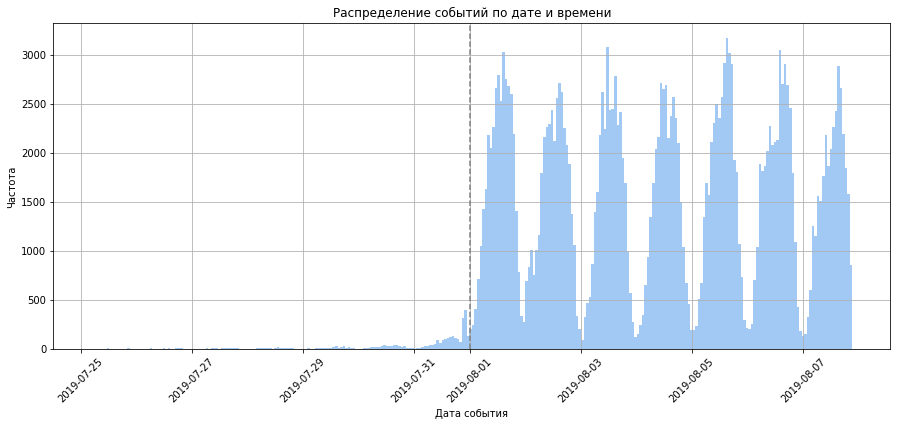

In [15]:
logs['datetime'].hist(bins=300, figsize=(15,6))
plt.title('Распределение событий по дате и времени')
plt.xlabel('Дата события')
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.axvline(x=datetime(2019, 8, 1).date(), color='grey', linestyle='--');

Можно заметить, что количество событий до 1 августа 2019 года очень небольшое, можно сделать вывод, что данные в этом периоде неполные. Для последующего анализа следует "отсечь" их. Посмотрим, сколько в таком случае отбрасыватся данных:

In [16]:
percent = len(logs.query('date < datetime(2019, 8, 1).date()'))/len(logs)
print(f'Процент отсеченных данных - {percent:.2%}')

Процент отсеченных данных - 1.16%


Убедившись в том, что доля отсченных данных очень небольшая, оставляем для дальнейшего исследования только информацию с 1 по 7 августа 2019 года:

In [17]:
logs = logs.query('date >= datetime(2019, 8, 1).date()')
logs.shape[0]

240887

По общему числу строк мы можем сделать вывод о количестве событий, которые у нас удалились. Однако, проверим скольких пользователей мы лишились в результате среза данных:

In [18]:
print('Количество пользователей в обновлённом логе:', len(logs['user_id'].unique()))
percent = 1-len(logs['user_id'].unique())/count_users
print(f'Процент удалённых пользователей - {percent:.2%}')

Количество пользователей в обновлённом логе: 7534
Процент удалённых пользователей - 0.23%


Мы потеряли только одного пользователя, что в относительном выражении всего 0.3%.

Для будущего анализа результатов экспримента необходимо убедиться в том, что у нас есть пользователи из всех трёх экспериментальных групп. Проверим наполняемость каждой группы:

In [19]:
# определим число событий и пользователей по каждой группе
group_logs = logs.groupby(by='group').agg({'event':'count', 'user_id':'nunique'})
# добавим столбец, где рассчитаем число событий на каждого пользователя
group_logs['events_per_user'] = round(group_logs['event']/group_logs['user_id'])
display(group_logs)

,event,user_id,events_per_user
group,,,
246,79302,2484,32.0
247,77022,2513,31.0
248,84563,2537,33.0


В результате "чистки" данных наполняемость наших экспериментальных групп не пострадала.

На этапе проверки данных мы установили период, за который собраны данные (с 25 июля 2019 года по 7 августа того же года). Однако, выяснили за первую неделю данные неполные, потому мы их удалили (в результате исследуемый период: с 1 по 7 августа 2019 года). После этого мы рассчитали количество пользователей и событий в каждой экспериментальной группе и убедились в том, что их наполняемость не пострадала. Среднее количество событий на одного пользователя также не изменилось (32 события в среднем как до, так и после "чистки" данных).

<a id='anchor_4'></a>
## Воронка событий

Посмотрим, какие события есть в логах и как часто они встречаются. Отсортируем события по частоте:  

In [20]:
logs['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

In [21]:
# посчитаем количество пользователей
len(logs['user_id'].unique())

7534

Самое популярное событие - загрузка главной страницы. Реже всего люди обращаются к руководству пользователя.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие:  

In [22]:
# определим число пользователей по каждому событию
event_logs = logs.groupby(by='event', as_index=False).agg({'user_id':'nunique'})

# добавим строку с общим числом пользователей
new_row = pd.Series(
    data={'event':'All_Users', 'user_id':len(logs['user_id'].unique())}, name='x')
event_logs = event_logs.append(new_row, ignore_index=False)

# отсортируем события по числу пользователей
event_logs = event_logs.sort_values(by='user_id', ascending=False).reset_index(drop=True)

# добавим столбец, где рассчитаем долю пользователей по каждому событию от общего числа пользователей
event_logs['percent_users'] = round(100*event_logs['user_id']/len(logs['user_id'].unique()), 2)
event_logs.style.format({'percent_users':'{:.2f}%'})

,event,user_id,percent_users
0,All_Users,7534,100.00%
1,MainScreenAppear,7419,98.47%
2,OffersScreenAppear,4593,60.96%
3,CartScreenAppear,3734,49.56%
4,PaymentScreenSuccessful,3539,46.97%
5,Tutorial,840,11.15%


Логично предположить, что события происходят в следующем порядке:

1) загрузка главной страницы,  
2) загрузка страницы товара,  
3) загрузка страницы "корзина",  
4) успешная оплата.  

Даже на первом шаге воронки мы не имеем 100% конверсии. Это может говорить о том, что пользователь может проходить сразу на страницу товара, минуя главную. Например, по прямой ссылке на эту страницу. Кроме того, в приложениях часто есть раздел с уже совершённымми заказами, где можно повторить заказ. В таком случае пользователь сразу окажется на странице "корзина".

К странице "руководство пользователя" покупатели обращаются вне зависимости от всех остальных событий. Таким образом, событие 'Tutorial' следует исключить при расчете воронки.  
Построим воронку событий, где посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

In [23]:
event_logs = event_logs.query('event != "Tutorial"')

fig = go.Figure(
    go.Funnel(
        y=event_logs['event'].unique(),
        x=event_logs['user_id'].unique(),
        textinfo = 'value + percent previous'
    )
)

fig.show() 

In [24]:
# рассчитаем, сколько пользователей проходят все этапы воронки - 
# от открытия главной страницы до проведения успешной оплаты
'{}{:.2%}'.format('Доля пользователей, прошедших все этапы воронки: ',
                  (event_logs.loc[4, 'user_id']/event_logs.loc[0, 'user_id']))

'Доля пользователей, прошедших все этапы воронки: 46.97%'

Из графика мы видим, что больше всего пользователей мы теряем на шаге "переход на страницу товара" - 38.1% пользователей, открывших главную страницу приложения, не переходят к следующему действию. Наименьшая потеря пользователей происходит на заключительном шаге - 94.8% пользователей, положивших товар в корзину, оформляют оплату.  
47.0% пользователей проходят все шаги - от открытия главной страницы до проведения успешной оплаты.

Интересно, как выглядит воронка событий в разрезе пользователей трёх групп. Построим такую воронку и посмотрим на то, согласуются ли данные разных групп между собой:

In [25]:
# сгруппируем данные по событиям и по группам
group_event_logs = (logs[logs['event']!='Tutorial'].pivot_table(
    index='event',
    columns='group',
    values='user_id',
    aggfunc='nunique').
                    sort_values(by=246, ascending=False).reset_index())
group_event_logs

group,event,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [26]:
# посчитаем число пользователей в каждой группе
group_event_total = (logs.pivot_table(
    columns='group',
    values='user_id',
    aggfunc='nunique').
                    sort_values(by=246, ascending=False))
group_event_total

group,246,247,248
user_id,2484,2513,2537


In [27]:
# объединим данные двух таблиц для будущей воронки

group_funnel = pd.concat([group_event_total, group_event_logs],
                         axis=0).set_index('event')
group_funnel = group_funnel.set_axis(['All_users',
                                     'MainScreenAppear',
                                     'OffersScreenAppear',
                                     'CartScreenAppear',
                                     'PaymentScreenSuccessful'],
                                     axis=0)
group_funnel

group,246,247,248
All_users,2484,2513,2537
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


In [28]:
# построим воронку событий с разбивкой по группам
fig = go.Figure()

for i in (246, 247, 248):
    fig.add_trace(go.Funnel(
        name=i,
        y= group_funnel.index.tolist(),
        x= group_funnel[i].tolist(),
        textinfo = 'value + percent previous'
    )
)
    
fig.show()

Мы видим, что тенденции поведения пользователей трёх групп аналогичны общей воронке: больше всего пользователей "теряется" при переходе с главной страницы на страницу товара и подавляющее большинство пользователей, положивших товар в корзину, проводят успешную оплату (94-96%). Доля пользователей по каждому шагу не имеет большого разрыва между группами и составляет буквально 1-2%.

Таким образом, изучив информацию о событиях, которые нашли отражение в нашей таблице, мы установили, что пользователь совершает 4 шага при приобретении товара:

1) загрузка главной страницы,  
2) загрузка страницы товара,  
3) загрузка страницы "корзина",  
4) успешная оплата.  

Руководство пользователя покупатели часто не смотрят, это событие мы исключили при расчете воронки событий. Построив воронку событий, мы выяснили, что больше всего пользователей "теряются" при переходе от главной страницы на страницу товара. Подавляющее большинство пользователей, положивших товар в корзину, проводят успешную оплату.

<a id='anchor_5'></a>
## Исследование результатов эксперимента

Переходим к анализу результатов А/В-теста. Для начала выясним, сколько пользователей и событий в каждой экспериментальной группе:  

In [29]:
# при анализе результатов А/В-теста событие 'Tutorial' также следует исключить
logs = logs.query('event != "Tutorial"')
# определим число событий и пользователей по каждой группе
group_exp = logs.groupby(by='group', as_index=False).agg(
    {'event':'count', 'user_id':'nunique'})
# добавим столбец, где рассчитаем число событий на каждого пользователя
group_exp['events_per_user'] = round(group_exp['event']/group_exp['user_id'])
display(group_exp)

,group,event,user_id,events_per_user
0,246,78985,2483,32.0
1,247,76684,2512,31.0
2,248,84213,2535,33.0


Мы видим, что небольшое различие в экспериментальных группах есть. Это говорит нам о неоптимальности разбиения данных по группам. Для будущих тестов следует несколько поработать с механикой выделения групп и, возможно, изменить подход к их выделению. Посмотрим, какова эта разница в процентном отношении:

In [30]:
a_aa = 1-group_exp.loc[0, 'user_id']/group_exp.loc[1, 'user_id']
print(f'Разница групп 246 и 247 составляет: {a_aa:.2%}')
a_b = 1-group_exp.loc[0, 'user_id']/group_exp.loc[2, 'user_id']
print(f'Разница групп 246 и 248 составляет: {a_b:.2%}')

Разница групп 246 и 247 составляет: 1.15%
Разница групп 246 и 248 составляет: 2.05%


Важным условием успешности проведения А/В-теста является отсутствие в группах пересекающихся значений. Проверим это для нашего случая:

In [31]:
print('Количество уникальных пользователей в трёх группах:', len( logs['user_id'].unique()))
# составим списки уникальных пользователей для каждой группы
group_a = logs.query('group == 246')['user_id'].unique()
group_aa = logs.query('group == 247')['user_id'].unique()
group_b = logs.query('group == 248')['user_id'].unique()
# выделим пересекающиеся значения в отдельный список
cross_users = np.intersect1d(group_b, group_a)
print(cross_users)
print('Количество пересекающихся значений в группах:', len(cross_users))

Количество уникальных пользователей в трёх группах: 7530
[]
Количество пересекающихся значений в группах: 0


In [32]:
cross_users = np.intersect1d(group_b, group_aa)
print(cross_users)
print('Количество пересекающихся значений в группах:', len(cross_users))

[]
Количество пересекающихся значений в группах: 0


In [33]:
cross_users = np.intersect1d(group_aa, group_a)
print(cross_users)
print('Количество пересекающихся значений в группах:', len(cross_users))

[]
Количество пересекающихся значений в группах: 0


Таким образом, мы не обнаружили пользователей, которые бы входили в состав нескольких групп одновременно.

### A/A-тест

Чтобы проверить корректность всех механизмов и расчётов, у нас есть 2 контрольные группы для А/А-эксперимента.  
Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для этого посчитаем долю каждой группы в общем чиcле пользователей и проверим гипотезы:

**H_0:** доли каждой группы в общем чиcле пользователей равны,  
**H_1:** доли каждой группы в общем чиcле пользователей отличаются.

Для проверки гипотезы о равенстве долей используем критерий со стандартным нормальным распределением (z_value): со средним, равным нулю, и стандартным отклонением, равным единице:

In [34]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([group_exp.loc[0, 'user_id'], group_exp.loc[1, 'user_id']])
trials = np.array([len(logs['user_id'].unique()), len(logs['user_id'].unique())])

# напишем функцию для расчета критерия z_value
def z_value(successes, trials):

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.6157227013842994
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом, не получилось отвергнуть нулевую гипотезу, нет оснований разницу между выборками 246 и 247 считать статистически значимой.

Найдём самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.

In [35]:
# определим число пользователей, совершиших событие по каждой группе
group_event_exp = logs.groupby(by=['group', 'event'], as_index=False).agg(
    {'user_id':'nunique'})
group_event_exp = group_event_exp.merge(
    group_exp[['user_id','group']].rename(columns = {'user_id':'all_users'}), on='group')
# добавим столбец, где рассчитаем долю пользователей, совершивших событие 
group_event_exp['successes_percent'] = 100*group_event_exp[
    'user_id']/group_event_exp['all_users']
group_event_exp = group_event_exp.sort_values(by='user_id',
                                              ascending=False).reset_index(drop=True)
group_event_exp.style.format({'successes_percent':'{:.2f}%'})

,group,event,user_id,all_users,successes_percent
0,248,MainScreenAppear,2493,2535,98.34%
1,247,MainScreenAppear,2476,2512,98.57%
2,246,MainScreenAppear,2450,2483,98.67%
3,246,OffersScreenAppear,1542,2483,62.10%
4,248,OffersScreenAppear,1531,2535,60.39%
5,247,OffersScreenAppear,1520,2512,60.51%
6,246,CartScreenAppear,1266,2483,50.99%
7,247,CartScreenAppear,1238,2512,49.28%
8,248,CartScreenAppear,1230,2535,48.52%
9,246,PaymentScreenSuccessful,1200,2483,48.33%


Самое популярное событие - "загрузка главной страницы". Проверим, будет ли отличие между группами 246 и 247 в части этого события статистически достоверным.  
Проверим гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

In [36]:
successes = np.array([group_event_exp.loc[2, 'user_id'],
                      group_event_exp.loc[1, 'user_id']])
trials = np.array([group_event_exp.loc[2, 'all_users'],
                   group_event_exp.loc[1, 'all_users']])

print('Событие: загрузка главной страницы')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Событие: загрузка главной страницы
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом, не получилось отвергнуть нулевую гипотезу, т.е. нет оснований считать доли пользователей, загрузивших главную страницу в каждой из групп 246 и 247, разными.

Проделаем то же самое для всех других событий. Проверим гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

In [37]:
successes = np.array([group_event_exp.loc[3, 'user_id'],
                      group_event_exp.loc[5, 'user_id']])

print('Событие: загрузка страницы товара')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# следующее событие
successes = np.array([group_event_exp.loc[6, 'user_id'],
                      group_event_exp.loc[7, 'user_id']])

print('')
print('Событие: загрузка страницы "корзина"')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[9, 'user_id'],
                      group_event_exp.loc[11, 'user_id']])

print('')
print('Событие: успешная оплата')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Событие: загрузка страницы товара
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы "корзина"
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: успешная оплата
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В результате по каждому событию мы получили одинаковый результат: нет оснований считать доли пользователей, совершивших действие в каждой из групп 246 и 247, разными. Таким образом, мы проанализировали результаты проведения А/А-теста, и можно сказать, что разбиение на группы работает корректно, так как различие ключевых метрик не имеет статистической значимости.

### A/B-тест

Поступим аналогично с группой с изменённым шрифтом (А/В-тест). Проверим гипотезы:

**H_0:** доли каждой группы в общем чиcле пользователей равны,  
**H_1:** доли каждой группы в общем чиcле пользователей отличаются.

In [38]:
successes = np.array([group_exp.loc[0, 'user_id'], group_exp.loc[2, 'user_id']])
trials = np.array([len(logs['user_id'].unique()), len(logs['user_id'].unique())])

print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.36867393977530094
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам А/В-теста не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 246 и 248 в общем числе пользователей разными.

Проделаем то же самое для каждого события в группах 246 и 248. Проверим гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

In [39]:
successes = np.array([group_event_exp.loc[2, 'user_id'],
                      group_event_exp.loc[0, 'user_id']])
trials = np.array([group_event_exp.loc[2, 'all_users'],
                   group_event_exp.loc[0, 'all_users']])

print('Событие: загрузка главной страницы')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[3, 'user_id'],
                      group_event_exp.loc[4, 'user_id']])

print('')
print('Событие: загрузка страницы товара')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# следующее событие
successes = np.array([group_event_exp.loc[6, 'user_id'],
                      group_event_exp.loc[8, 'user_id']])

print('')
print('Событие: загрузка страницы "корзина"')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[9, 'user_id'],
                      group_event_exp.loc[10, 'user_id']])

print('')
print('Событие: успешная оплата')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Событие: загрузка главной страницы
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы товара
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы "корзина"
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: успешная оплата
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы получили одинаковый результат по всем событиям в группах 246 и 248: нет оснований считать доли пользователей, совершивших действие в каждой из групп, разными. Таким образом, мы проанализировали результаты проведения А/В-теста, и можно сказать, что различие ключевых метрик не имеет статистической значимости.

Проведём аналогичный тест для групп 247 и 248. Сначала для общего числа пользователей в группе по отношении числу пользователей в всех трёх группах. Проверим гипотезы:

**H_0:** доли каждой группы в общем чиcле пользователей равны,  
**H_1:** доли каждой группы в общем чиcле пользователей отличаются.

In [40]:
successes = np.array([group_exp.loc[1, 'user_id'], group_exp.loc[2, 'user_id']])
trials = np.array([len(logs['user_id'].unique()), len(logs['user_id'].unique())])

print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.6913330430967497
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам А/В-теста не получилось отвергнуть нулевую гипотезу, нет оснований считать доли групп 247 и 248 в общем числе пользователей разными.

Проделаем то же самое для каждого события в группах 247 и 248. Проверим гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

In [41]:
successes = np.array([group_event_exp.loc[1, 'user_id'],
                      group_event_exp.loc[0, 'user_id']])
trials = np.array([group_event_exp.loc[1, 'all_users'],
                   group_event_exp.loc[0, 'all_users']])

print('Событие: загрузка главной страницы')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[5, 'user_id'],
                      group_event_exp.loc[4, 'user_id']])

print('')
print('Событие: загрузка страницы товара')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# следующее событие
successes = np.array([group_event_exp.loc[7, 'user_id'],
                      group_event_exp.loc[8, 'user_id']])

print('')
print('Событие: загрузка страницы "корзина"')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[11, 'user_id'],
                      group_event_exp.loc[10, 'user_id']])

print('')
print('Событие: успешная оплата')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Событие: загрузка главной страницы
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы товара
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы "корзина"
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: успешная оплата
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы получили одинаковый результат по всем событиям в группах 247 и 248: нет оснований считать доли пользователей, совершивших действие в каждой из групп, разными. Таким образом, мы проанализировали результаты проведения А/В-теста, и можно сказать, что различие ключевых метрик не имеет статистической значимости.

### Тест для объединённой А группы и группы В

Сравним результаты с объединённой контрольной группой (группа 246 + группа 247). Посмотрим, какие выводы из эксперимента можно будет сделать. Проверим гипотезы:

**H_0:** доли объединённой контрольной группы и группы с изменённым шрифтом в общем числе пользователей равны,  
**H_1:** эти доли отличаются.

In [42]:
successes = np.array([group_exp.loc[0, 'user_id']+group_exp.loc[1, 'user_id'],
                      group_exp.loc[2, 'user_id']])
trials = np.array([len(logs['user_id'].unique()), len(logs['user_id'].unique())])

print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Мы отвергли нулевую гипотезу в пользу альтернативной. Это вполне предсказуемый результат, т.к. объединённая контрольная группа примерно вдвое больше группы с изменённым шрифтом, соответственно удельный вес этой группы составляет около двух третей от общего числа пользователей против одной трети, которая приходится на группу 248. Таким образом, разницу между долями можно считать статистически значимой.

Изучим разницу долей объединённой группы и группы с изменнённым шрифтом для каждого события. Проверим гипотезы:

**H_0:** доли пользователей объединённой контрольной группы и группы с изменённым шрифтом, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

In [43]:
successes = np.array([group_event_exp.loc[1, 'user_id']+group_event_exp.loc[2, 'user_id'],
                      group_event_exp.loc[0, 'user_id']])
trials = np.array([
    group_event_exp.loc[1, 'all_users']+group_event_exp.loc[2, 'all_users'],
    group_event_exp.loc[0, 'all_users']])

print('Событие: загрузка главной страницы')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[3, 'user_id']+group_event_exp.loc[5, 'user_id'],
                      group_event_exp.loc[4, 'user_id']])

print('')
print('Событие: загрузка страницы товара')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# следующее событие
successes = np.array([group_event_exp.loc[6, 'user_id']+group_event_exp.loc[7, 'user_id'],
                      group_event_exp.loc[8, 'user_id']])

print('')
print('Событие: загрузка страницы "корзина"')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
    
# следующее событие
successes = np.array([group_event_exp.loc[9, 'user_id']+group_event_exp.loc[11, 'user_id'],
                      group_event_exp.loc[10, 'user_id']])

print('')
print('Событие: успешная оплата')
print('p-значение: ', z_value(successes, trials))

if z_value(successes, trials) < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Событие: загрузка главной страницы
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы товара
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: загрузка страницы "корзина"
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: успешная оплата
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы получили одинаковый результат по всем событиям в объединённой контрольной группе (группа 246 + группа 247) и группе с изменённм шрифом (248): нет оснований считать доли пользователей, совершивших действие в каждой из групп, разными. Таким образом, мы проанализировали результаты проведения А/В-теста, и можно сказать, что различие ключевых метрик не имеет статистической значимости. Нет оснований полагать, что изменённый шрифт влияет на поведение пользователей как в лучшую, так и в худшую сторону.

Мы тестировали нашу гипотезу в разных вариациях - это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения группового коэффициента ошибок. Самая грубая и распространённая поправка к требуемым уровням значимости - *Метод Бонферрони (поправка Бонферрони)*. Суть данного метода заключается в том, что уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Проще говоря, делят уровень значимости ɑ на число гипотез. Однако в нашем эксперименете нет смысла применять поправочный коэффициент, т.к. все нулевые гипотезы не удалось отвергнуть при выбранном нами уровне значимости ɑ = 0.05. При данном уровне значимости каждый пятидесятый раз можно получать ложный результат. В результате нашего А/В-теста мы проверили 16 гипотез (по 2 гипотезы на каждое из 4-х событий при попарном сравнении трёх групп). Таким образом, нет шанса принять альтернативную гипотезу сравнивая расчетное z_value с уровнем ɑ, уменьшенным ещё в 16 раз.  
Вместе с тем, имеет смысл изучить, какой уровень различий между группами критичен. Так, например, разница между группами может не превышать и процента, а "вылиться" компании в большие убытки. Возникает ошибка второго рода. Таким образом, приходится выбирать, что для нас важнее - значимость или мощность теста.

Мы изучили результаты проведения А/А/В-теста. Сравнили, есть ли разница между долями пользователей, совершивших событие в каждой из двух контрольных групп и в группе с изменённым шрифтом. Проверяли следующие гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

Для всех событий и для всех групп мы получили одинаковый результат: нет оснований считать доли пользователей, совершивших действие в каждой из групп, разными. Различие ключевых метрик не имеет статистической значимости. Далее мы проверили результаты ещё раз, сравнивая объединённую контрольную группу и группу с изменённым шрифтом - получили тот же результат. Таким образом, нет оснований полагать, что изменённый шрифт влияет на поведение пользователей как в лучшую, так и в худшую сторону.

<a id='anchor_6'></a>
## Общий вывод

Мы познакомились с данными, устранили явные дубликаты и адаптировали таблицу для исследования.  

Мы установили период, за который собраны данные (с 25 июля 2019 года по 7 августа того же года). Однако, выяснили, что за первую неделю данные неполные, потому мы их удалили (в результате исследуемый период: с 1 по 7 августа 2019 года). После этого мы рассчитали количество пользователей и событий в каждой экспериментальной группе и убедились в том, что их наполняемость не пострадала. Среднее количество событий на одного пользователя также не изменилось (32 события в среднем как до, так и после "чистки" данных). Вместе с тем, в массиве данных имеются пользователи, которые совершили аномально много действий. В силу этого средняя величина завышает "типичное" для пользователя количество действий. Медианное значение показателя - 20 событий на пользователя.

Построили воронку событий. Выяснили, что больше всего пользователей мы теряем на шаге "переход на страницу товара" - 38.1% пользователей, открывших главную страницу приложения, не переходят к следующему действию. Наименьшая потеря пользователей происходит на заключительном шаге - 94.8% пользователей, положивших товар в корзину, оформляют оплату.  
47.0% пользователей проходят все шаги - от открытия главной страницы до проведения успешной оплаты.

Таким образом, изучив информацию о событиях, которые нашли отражение в данных исследования, мы установили, что пользователь совершает 4 шага при приобретении товара:

загрузка главной страницы → загрузка страницы товара → загрузка страницы "корзина" → успешная оплата.  

Руководство пользователя покупатели часто не смотрят, это событие мы исключили при расчете воронки событий.

Мы изучили результаты проведения А/А/В-теста. Сравнили, есть ли разница между долями пользователей, совершивших событие в каждой из двух контрольных групп и в группе с изменённым шрифтом. Проверяли следующие гипотезы:

**H_0:** доли пользователей, совершивших событие, в общем чиcле пользователей группы равны,  
**H_1:** эти доли отличаются.

Для всех событий и для всех групп мы получили одинаковый результат: нет оснований считать доли пользователей, совершивших действие в каждой из групп, разными. Различие ключевых метрик не имеет статистической значимости. Далее мы проверили результаты ещё раз, сравнивая объединённую контрольную группу и группу с изменённым шрифтом - получили тот же результат. Таким образом, нет оснований полагать, что изменённый шрифт влияет на поведение пользователей как в лучшую, так и в худшую сторону. Изменение шрифтов можно провести, однако это не увеличит показатели.

Мы тестировали нашу гипотезу в разных вариациях - это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения группового коэффициента ошибок. Самая грубая и распространённая поправка к требуемым уровням значимости - *Метод Бонферрони (поправка Бонферрони)*. Суть данного метода заключается в том, что уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Проще говоря, делят уровень значимости ɑ на число гипотез. Однако в нашем эксперименете нет смысла применять поправочный коэффициент, т.к. все нулевые гипотезы не удалось отвергнуть при выбранном нами уровне значимости ɑ = 0.05. При данном уровне значимости каждый пятидесятый раз можно получать ложный результат. В результате нашего А/В-теста мы проверили 16 гипотез (по 2 гипотезы на каждое из 4-х событий при попарном сравнении трёх групп). Таким образом, нет шанса принять альтернативную гипотезу сравнивая расчетное z_value с уровнем ɑ, уменьшенным ещё в 16 раз.  
Вместе с тем, имеет смысл изучить, какой уровень различий между группами критичен. Так, например, разница между группами может не превышать и процента, а "вылиться" компании в большие убытки. Возникает ошибка второго рода. Таким образом, приходится выбирать, что для нас важнее - значимость или мощность теста.